# Support Vector Machines

__WARNING: LOTS OF MATH AND $\LaTeX$ HERE!__

A *Support Vector Machine* (SVM) is a extremely powerful Machine Learning model that is capable of performing linear or nonlinear classification, regression, and even outlier detection.

## Linear SVM Classification

The fundamental idea behind SVMs is that they try to differentiate between classes that can be separated by lines (e.g. classes that are *linearly separable*). An SVM classifier can be thought as fitting the widest possible street between the classes, something that is called *large margin classification*.

Adding in more training instances won't affect the decision boundary; it's fully determined (supported) by the instances located on the edge of the street. These instances are called *support vectors*.

*Note: SVMs are sensitive to the features scales. Scaling with the `StandardScaler` makes for much better classifiers*

### Soft Margin Classification

If we strictly impose that all instances be off the street and on the right side, this is called *hard margin classification*. There are two issues with this:

1) It only works if the data is linearly separable

2) it is quite sensitive to outliers

To avoid these issues, it's preferable to use a more flexible model. The goal is to find a good balance between keeping the street as large as possible and limiting *margin violations* (instances that end up in the middle of the street or even on the wrong side). This is known as *soft margin classification*.

In SKLearn, this balance can be controlled by using the `C` hyperparameter. A smaller `C` value leads to a wider street but more margin violations.

*Note: if your model is overfitting, you can try regularizing it by reducing `C`.*

The following code will load the iris dataset again, scales the features, and then trains a linear SVM model using the `LinearSVC` class with `C` = 1 and the *hinge loss* function, which will be described in a bit.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)] # petal length, petal width
y = (iris['target'] == 2).astype(np.float64) # Iris-Virginica

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [2]:
# use the model to make predicitions
svm_clf.predict([[5.5, 1.7]])

array([1.])

Alternatively, you could use the `SVC` class with `SVC(kernel='linear', C=1)`, but it's slower (especially with large training sets) so it's not recommended. Another option is to use the `SGDClassifier` class, with `SGDClassifier(loss='hinge', alpha=1/(m*C))`. This applies regular Stochastic Gradient Descent to train a linear SVM classifier. It doesn't converge as fast as the `LinearSVC` class, but it can be useful to handle huge datasets that don't fit in memory (out of core training) or to handle online classification tasks.

*Note: The `LinearSVC` class regularizes the bias term, so you should center the training set first by subtracting its mean. This is automatically done if you scale the data with the `StandardScaler`. Moreover, make sure that the `loss` hyperparameter is set to "`hinge`", since that's not the default value. Lastly, for better performance, the `dual` hyperparameter should be set to `False` unless there are more features than training instances.*

## Nonlinear SVM Classification

Linear SVM classifiers are pretty efficient and work surprisingly well in many cases, but many datasets aren't anywhere close to being linearly separable. One approach to handing nonlinear datasets is to add more features, such as polynomial features (like in Chapter 4). In some cases, this can result in a linearly separable dataset.

To implement this idea using SKlearn, you can create a `Pipeline` containing a `PolynomialFeatures` transformer followed by a `StandardScaler` and a `LinearSVC`. Let's test this on the moons dataset.

In [3]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

In [4]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge'))
])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

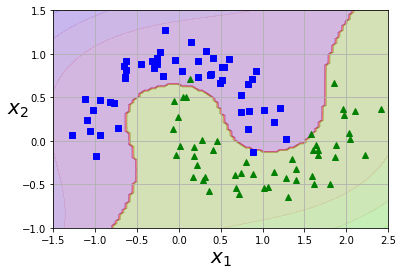

In [5]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

# This graph shows a linear SVM classifier using polynomial features

### Polynomial Kernel

Adding polynomial features is simple to implement (as seen above) and can work great with all sorts of ML algos, but at low degrees it can't deal with very complex datasets, and at high degrees is creates a huge number of features (slowing down the model significantly).

When using SVMs, there's a nice mathematical technique known as the *kernel trick* that can be used. It makes it possible to get the same result as if you added many polynomial features, even with very high degree polynomials, without actually having to add them. This saves from having a combinatorial explosion in feature numbers. This trick is implemented in the `SVC` class, so let's try it on the moons dataset.

In [6]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

The above code trains an SVM classifier using a $3^{rd}$ degree polynomial kernel. If the model is overfitting, reducing the polynomial degree may help. Conversely, if it's underfitting, you can try increasing the polynomial degree.

The `coef0` hyperparameter controls how much the model is influenced by high degree polynomials vs low degree polynomials.

*Note: A common approach is to find the right hyperparameter values using grid search. It's often faster to do a coarse grid search first, then to do a finer grid search around the best values found. Having a good sense of what each hyperparameter actually does can also help you search in the right part of the hyperparameter space.*

### Adding Similarity Features

Another technique to tackle nonlinear problems is to add features computed using a *similarity function* that measures how much each instance resembles a particular *landmark*. A common similarity function is the Gaussian *Radial Basis Function* (RBF), defined as follows:

$$\phi_\gamma(\textbf{x}, \ell) = e^{-\gamma\|\textbf{x} - \ell\|^2}$$

This function is bell-shaped varying from 0 (far away from the landmark) to 1 (at the landmark).

A natural question is how to select the landmarks. The simplest approach is to create a landmark at the location of each and every instance in the dataset. This creats many dimensions (and thus increases the chances that the transformed set will be linearly separable. The downside of this is that a training set with $m$ instances and $n$ features gets transformed into a training set with _m_ instances and *m* features (assuming you drop the original features). If the training set is large, you end up with an equally large number of features.

### Gaussian RBF Kernel

Just like with polynomial features, the similarity features method can be useful with any ML algo, but it may be computationally expensive to compute all of the additional features (especially on large training sets). However, the kernel trick once again does its magic on SVMs; it makes it possible to obtain a similar result as if you'd added many similarity features without actually having to add them. Let's try the Gaussian RBF kernel using the `SVC` class

In [7]:
rbf_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Increasing the `gamma` ($\gamma$) hyperparameter makes the bell shaped curve narrower, and as a result, each instance's range of influence is smaller; the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small `gamma` value makes the bell-shaped curve wider, so instances have a larger range of influence and the decision boundary ends up smoother. So, $\gamma$ acts like a regularization hyperparameter; if the model is overfitting, you should reduce it, and if it is underfitting, you should increase it (similar to the `C` hyperparameter).

Other kernels exist but aren't used as commonly. Some kernels, for example, are specialized for specific data structures. *String kernels* are sometimes used when classifying text documents or DNA sequences (e.g. using the *string subsequence kernel* or kernels based on the *Levenshtein distance*)

*Note: how do you decide which kernel to use with so many available options? For a starting rule, the linear kernel should be tried first (remember that `LinearSVC` is faster than `SVC(kernel='linear')`), especially if the training set is very large or if it has plenty of features. If the training set isn't too large, you should use the Gaussian RBF kernel as well; it works well in most cases. Lastly, if you have spare time and computing power, a few other kernels can be experimented with using cross-validation and grid search, especially if there are kernels specialized for your training set's data structure.*

### Computational Complexity

The `LinearSVC` class is based on the *liblinear* library, which implements an optimized [algorithm](https://goo.gl/R635CH) for linear SVMs. It doesn't support the kernel trick, but it scales almost linearly with the number of training instances and the number of featues (complexity is roughly $O(m \text{ x } n)$).

The algo takes longer if you require a very high precision. This is controlled by the tolerance hyperparameter $\varepsilon$, (called `tol` in sklearn). In most classification tasks, the default tolerance is fine.

The `SVC` class is based on the *libsvm* library, which implements an [algorithm](https://goo.gl/a8HkE3) that supports the kernel trick. The training time complexity is usually between $O(m^2 \text{ x } n)$ and $O(m^3 \text{ x } n)$. Unfortuantely, this means that it gets dreadfully slow when the number of training instances gets large (hundreds of thousands of instances). This algo is perfect for complex but small or medium training sets. However, it scales well with the number of features, especially with *sparse features* (each instance has few nonzero features). In this case, the algo scales roughly with the average number of nonzero features per instances. The following table compares sklearn's SVM classification classes

Class | Time complexity | Out-of-core support | Scaling required | Kernel trick
:---: | :---: | :---: | :---: | :---: |
`LinearSVC` | $O(m \text{ x }  n)$ | No | Yes | No
`SGDClassifier` | $O(m \text{ x } n)$ | Yes | Yes | No
`SVC` | $O(m^2 \text{ x } n)$ to $O(m^3 \text{ x } n)$ | No | Yes | Yes

## SVM Regression

As mentioned earlier, the SVM algo is quite versatile; it supports linear/nonlinear regression as well as linear/nonlinear classification. The trick is to reverse the objective; instead of trying to fit the largest possible street between the two classes while limiting margin violations, SVM Regression tries to fit as many instances as possible *on* the street while limiting margin violations (i.e. instances *off* the street). The width of the street is controlled by a hyperparameter $\varepsilon$.

Adding more training instances within the margin doesn't affect the model's predictions; thus, the model is said to be *$\varepsilon$-insensitive*.

You can use sklearn's `LinearSVR` class to perform linear SVM Regression. The following code produces the model represented on page 157. The data should be scaled and centered first

In [8]:
# Generate random data
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

from sklearn.svm import LinearSVR, SVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

For nonlinear regression tasks, you can use a kernelized SVM model. The `SVC` is sklearn's regression equivalent of SVC (and it supports the kernel trick) and `LinearSVR` is the regression equivalent of the `LinearSVC` class. The `LinearSVR` class scales linearly with the size of the training set (like the `LinearSVC` class) while the `SVR` class gets much too slow when the training set grows large (just like the `SVC` class).

In [9]:
svm_poly_reg = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## Under the Hood

*Note: the bias term will be called $b$ and the feature weights vector will be called $\textbf{w}$.*

### Decision Function and Predictions

The linear SVM classifier model predicts the class of a new instance $\textbf{x}$ by computing the decision function $\textbf{w}^T \cdot \textbf{x} + b = w_1x_1 + \cdots + w_nx_n + b$. If the result is positive, the predicted class $\hat{y}$ is the positive class (1); else, it is the negative class 0. The following piecewise function summarizes the relationship:

$$\begin{align*}\hat{y} = \left\{ \begin{array}{ll} 0 &&\text{ if } \textbf{w}^T \cdot \textbf{x} + b \lt 0 &&\\ 1 &&\text{ if } \textbf{w}^T \cdot \textbf{x} + b \geq 0\end{array}\right.\end{align*}$$

The below graph plots out a decision function plane. The decision boundary is the set of points where the decision function is equal to 0; it's the intersection of the two planes (which is a line represented by the thick solid line).

In [10]:
# Load the iris dataset
iris = datasets.load_iris()
X = iris['data'][:, (2, 3)] # petal length, petal width
y = (iris['target'] == 2).astype(np.float64) # Iris-Virginica

svm_clf2 = LinearSVC(C=100, loss='hinge', random_state=42)
scaler = StandardScaler()
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf2.intercept_ = np.array([b2])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf2.support_vectors_ = X[support_vectors_idx2]

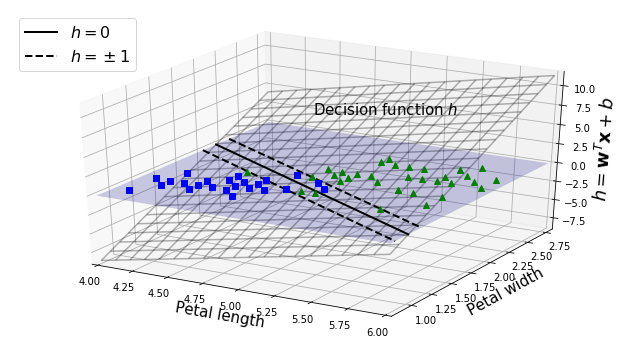

In [11]:
# create a super sick 3d plot
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=15)
    ax.set_xlabel(r"Petal length", fontsize=15)
    ax.set_ylabel(r"Petal width", fontsize=15)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])
plt.show()

The dashed lines represent the points where the decision function is equal to 1 or -1; they are parallel and at equal distance to the decision boundary, forming a margin around it. Training a linear SVM classifier means finding the value of $\textbf{w}$ and $b$ that make this margin as wide as possible whilst avoiding margin violations (hard margin) or limiting them (soft margin).

### Training Objective

The slope of our decision function is equal to the norm of the weight vector (denoted $\|\textbf{w}\|$). If we divide this slope by 2, the points where the decision function is equal to $\pm 1$ are gonna be twice as far away from the decision boundary. Basically, dividing by 2 will multiply the margin by 2.

We want to minimize $\|\textbf{w}\|$ to get a large margin. However, if we also want to avoid any hard margins, we need the decision function to be __greater than 1__ for all positive training instances, and __lower than -1__ for negative training instances. If we define $t^i = -1$ for negative instances (if $y^i = 0$) and $t^i = 1$ for positive instances (if $y^i = 1$) then we can express this constraint as $t^i(\textbf{w}^T \cdot \textbf{x}^i + b) \geq 1$ for all instances.

Therefore, the hard margin linear SVM classifier objective can be expressed as the *constrained optimization* problem given below:

$$\mathop{\text{minimize}}_{\textbf{w}, b} \frac{1}{2}\textbf{w}^T \cdot \textbf{w} \\ \text{subject to } t^i(\textbf{w}^T \cdot \textbf{x}^i + b) \geq 1 \text{ for } i = 1,2, \cdots, m$$

*Note: the reason we're minimizing that function is because it has a nice derivative while $\|\textbf{w}\|$ isn't differentiable at 0. Optimization algos work better on differentiable functions*

To get the soft margin objective, we need a *slack variable* $\zeta \geq 0$ for each instance. $\zeta$ measures how much the $i^{th}$ instance is allowed to violate the margin. This introduces a conflicting objective; making the slack variables as small as possible to reduce the margin violations, and making $\frac{1}{2}\textbf{w}^T \cdot \textbf{w}$ as small as possible to increase the margin. This is where the `C` hyperparameter comes in; it allows us to define the trade-off between the two objectives. This gives us the constrained optimization problem seen below:

$$\mathop{\text{minimize}}_{\textbf{w}, b, \zeta} \frac{1}{2}\textbf{w}^T \cdot \textbf{w} + C\sum_{i=1}^m\zeta^i \\ \text{subject to } t^i(\textbf{w}^T \cdot \textbf{x}^i + b) \geq 1 - \zeta^i \text{ and } \zeta^i \geq 0 \text{ for } i = 1,2,\cdots, m$$

### Quadratic Programming

Both the hard and soft margin problems are examples of convex quadratic optimization problems with linear constraints. Such problems are known as *Quadratic Programming* problems. There are many solvers available to solve these problems using a variety of techniques that are too complex for right now, but can be learned about [here](https://goo.gl/FGXuLw) or [here](https://goo.gl/rTo3Af). The general problem formulation is given below:

$$\mathop{\text{Minimize}}_{\textbf{p}} \frac{1}{2}\textbf{p}^T\cdot\textbf{H}\cdot\textbf{p} + \textbf{f}^T\cdot\textbf{p} \\ \text{subject to } \textbf{A} \cdot \textbf{p} \leq \textbf{b} \\ \text{where } \begin{align*}\left\{\begin{array}{ll} \textbf{p} &\text{ is an }n_p\text{-dimensional vector } (n_p = \text{ number of parameters}), \\ \textbf{H} &\text{ is an }n_p \text{ x } n_p \text{ matrix}, \\ \textbf{f} &\text{ is an }n_p\text{-dimensional vector}, \\ \textbf{A} &\text{ is an }n_c \text{ x } n_p \text{ matrix } (n_c = \text{ number of constraints}), \\ \textbf{b} &\text{ is an }n_c\text{-dimensional vector}\end{array}\right.\end{align*}$$

Notice that the expression $\textbf{A} \cdot \textbf{p} \leq \textbf{b}$ actually defines $n_c$ constraints; $\textbf{p}^T \cdot \textbf{a}^i \leq b^i$ for $i = 1,2,\cdots,n_c$ where $\textbf{a}^i$ is the vector containing the elements of the $i^{th}$ row of $\textbf{A}$ and $b^i$ is the $i^{th}$ element of $\textbf{b}$.

You can easily verify that setting the QP parameters in the following way, you get the hard margin linear SVM classifier objcetive seen above:

* $n_p = n+1$, where $n$ is the number of features (the +1 is for the bias term)
* $n_c = m$, where $m$ is the number of training instances
* $\textbf{H}$ is the $n_p x n_p$ identity matrix, except with a zero in the top-left cell (to ignore the bias term)
* $\textbf{f} = 0$, an $n_p$-dimensional vector full of 0s
* $\textbf{b} = 1$, an $n_c$-dimensional vector full of 1s
* $\textbf{a}^i = -t^i\dot{\textbf{x}}^i$, where $\dot{\textbf{x}}^i$ is equal to $\textbf{x}^i$ with an extra bias feature $\dot{\textbf{x}}_0 = 1$

So, one way to train a hard margin linear SVM classifier is to just use an off-the-shelf QP solver by passing it those aforementioned parameters. The resulting vector $\textbf{p}$ will contain the bias term $b = p_0$ and the feature weights $w_i = p_i$ for $i=1,2,\cdots,m$. Similarly, you can use a QP solver to solve the soft margin problem (see the exercises at the end).

However, to use the kernel trick, we're gonna look at a different constrained optimization problem.

### The Dual Problem

Given a constrained optimization problem, known as the *primal problem*, it is possible to express a different but closely related problem, called its *dual problem*. The solution to the dual problem typically gives a lower bound to the solution of the primal problem, but under some conditions it can even have the same solutions as the primal problem. Luckily, the SVM problem happens to meet these conditions, so you can choose to solve the primal problem or the dual problem; both will have the same solution! The following equation shows the dual form of the linear SVM objective. *Note: This function is convex, and the inequality constraints are continuously differentiable and convex functions.*

$$\mathop{\text{minimize}}_\alpha \frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\alpha^i\alpha^jt^it^j\textbf{x}^{i^T}\cdot\textbf{x}^j - \sum_{i=1}^m\alpha^i \\ \text{subject to } \alpha^i \geq 0 \text{ for } i=1,2,\cdots,m$$

Once you find the vector $\hat{\alpha}$ that minimizes this equation (using a QP solver), you can compute $\hat{\textbf{w}}$ and $\hat{b}$ that minimize the primal problem by using the following equations:

$$\hat{\textbf{w}} = \sum_{i=1}^m\hat{\alpha}t^i\textbf{x}^i \\ \hat{b} = \frac{1}{n_s}\mathop{\sum_{i=1}^m}_{\hat{\alpha}^i \lt 0}\Big(t^i - \hat{\textbf{w}}^T \cdot \textbf{x}^i\Big)$$

The dual problem is faster to solve than the primal when the number of training instances is smaller than the number of features. More importantly, it makes the kernel trick possible, whiile the primal doesn't. But what *exactly* is the kernel trick?

### Kernelized SVM

Say you want to apply a $2^{nd}$-degree polynomial transformation to a 2D training set (such as the moons training set from earlier), then train a linear SVM classifier on the transformed training set. The next equation shows the $2^{nd}$-degree polynomial mapping function $\phi$ that you want to apply:

$$\phi(\textbf{x}) = \phi\Bigg(\begin{vmatrix}x_1\\x_2\end{vmatrix}\Bigg) = \begin{vmatrix}x_1^2\\ \sqrt{2}x_1x_2\\ x_2^2\end{vmatrix}$$

Notice that the transformed vector is 3D instead of 2D. Now let's look at what happens to a couple of 2D vectors $\textbf{a}$ and $\textbf{b}$, if we apply this $2_{nd}$-degree polynomial mapping and then compute the dot product of the transformed vectors (see the next equation):

$$\phi(\textbf{a})^T \cdot \phi(\textbf{b}) = \begin{vmatrix}a_1^2\\ \sqrt{2}a_1a_2 \\ a_2^2\end{vmatrix} \cdot \begin{vmatrix}b_1^2\\ \sqrt{2}b_1b_2\\ b_2^2\end{vmatrix} = a_1^2b_1^2 + 2a_1b_1a_2b_2 + a_2^2b_2^2 = (a_1b_1 + a_2b_2)^2 = \Bigg(\begin{vmatrix}a_1\\a_2\end{vmatrix}^T \cdot \begin{vmatrix}b_1\\b_2\end{vmatrix}\Bigg)^2 = (\textbf{a}^T \cdot \textbf{b})^2$$

We've found that the dot product of the transformed vectors is equal to the square of the dot product of the original vectors. In other words, $\phi(\textbf{a})^T \cdot \phi(\textbf{b}) = (\textbf{a}^T \cdot \textbf{b})^2$.

Now for the important part (in bold): __if you apply the transformation $\phi$ to all training instances, then the dual problem will contain the dot product $\phi(\textbf{x}^i)^T \cdot \phi(\textbf{x}^j)$. But if $\phi$ is the $2^{nd}$-degree polynomial transformation seen above, then you can replace this dot product of transformed vectors simply by $\Big(\textbf{x}^{i^T} \cdot \textbf{x}^j\Big)^2$. This means that you don't actually need to transform the training instances at all; just replace the dot product by its square in the equation two spots up. The result will be strictly the same as if you went through the trouble of actually transforming the training set then fitting a linear SVM algo, but this trick makes the whole process much more computationally efficient__. This is the essence of the kernel trick!

The function $K(\textbf{a}, \textbf{b}) = (\textbf{a}^T \cdot \textbf{b})^2$ is called a $2^{nd}$-degree *polynomial kernel*. In ML, a *kernel* is a function capable of computing the dot product $\phi(\textbf{a})^T \cdot \phi(\textbf{b})$ based only on the original vectors $\textbf{a} \text{ and } \textbf{b}$ without having to compute (or even *know* about) the transformation $\phi$. The next grouping of equations list out some of the most commonly used kernels:

* Linear: $K(\textbf{a}, \textbf{b}) = \textbf{a}^T \cdot \textbf{b}$
* Polynomial: $K(\textbf{a}, \textbf{b}) = \Big(\gamma\textbf{a}^T \cdot \textbf{b} + r\Big)^d$
* Gaussian RBF: $K(\textbf{a}, \textbf{b}) = \exp\Big(-\gamma\|\textbf{a} - \textbf{b}\|^2\Big)$
* Sigmoid: $K(\textbf{a}, \textbf{b}) = \tanh\Big(\gamma\textbf{a}^T\cdot\textbf{b} + r\Big)$

#### Mercer's Theorem, a Sidenote
According to the theorem, if a function $K(\textbf{a}, \textbf{b})$ respects a few condtions known as *Mercer's conditions* ($K$ must be continuous, symmetric in its arguments ($K(\textbf{a}, \textbf{b}) = K(\textbf{b}, \textbf{a})$, and more) then there exists a function $\phi$ which maps $\textbf{a}$ and $\textbf{b}$ into another space (possibly with much higher dimensions) such that $K(\textbf{a}, \textbf{b}) = \phi(\textbf{a})^T \cdot \phi(\textbf{b})$. This means that you can use $K$ as a kernel since you know $\phi$ exists, even if you don't know what it is. *In the case of Gaussian RBF kernel, it can be shown that $\phi$ actually maps each training instance to an infinite-dimensional space*.
#### End Sidenote

There's still a problem to address. We can go from the dual solution to the primal solution with a linear SVM, but if you apply the kernel trick you end up with equations that include $\phi(x^i)$, which may be huge (or even infinite) so they can't be computed. But how can you make predictions without knowing what $\hat{\textbf{w}}$ is? Luckily, you can plug in the formula for $\hat{\textbf{w}}$ into the decision function for a new instance $\textbf{x}^n$, and you get an equation with only dot products between input vecotrs. This makes the kernel trick possible, once again. See below for details:

$$\begin{align*}h_{\hat{\textbf{w}}, \hat{b}}\Big(\phi\Big(\textbf{x}^n\Big)\Big) &= \hat{\textbf{W}}^T \cdot \phi(\textbf{x}^n) + \hat{b} = \Big(\sum_{i=1}^m\hat{\alpha}^it^i\phi(\textbf{x}^i)\Big)^T \cdot \phi(\textbf{x}^n) + \hat{b} \\ &= \sum_{i=1}^m\hat{\alpha}^it^i\Big(\phi(\textbf{x}^i)^T\cdot\phi(\textbf{x}^n)\Big) + \hat{b} \\ &= \mathop{\sum_{i=1}^m}_{\hat{\alpha}^i \gt 0}\hat{\alpha}^it^iK\Big(\textbf{x}^i,\textbf{x}^n\Big)+\hat{b}\end{align*}$$

Note that since $\alpha^i \neq 0$ only for support vectors, making predictions involves computing the dot product of the new input vector $\textbf{x}^n$ with only the support vectors, not all of the training instances. Of course, the bias term $\hat{b}$ also needs to be computed using the same trick. See equation below:

$$\begin{align*}\hat{b} &= \frac{1}{n_s}\mathop{\sum_{i=1}^m}_{\hat{\alpha}^i \gt 0}\Big(1 - t^i\hat{\textbf{w}}^T \cdot \phi(\textbf{x}^i)\Big) = \frac{1}{n_s}\mathop{\sum_{i=1}^m}_{\hat{\alpha}^i \gt 0}\Bigg(1 - t^i\Big(\sum_{j=1}^m\hat{\alpha}^jt^j\phi(\textbf{x}^j)\Big)^T\cdot\phi(\textbf{x}^i)\Bigg)\\
&= \frac{1}{n_s}\mathop{\sum_{i=1}^m}_{\hat{\alpha}^i \gt 0}\Bigg(1-t^i\mathop{\sum_{j=1}^m}_{\hat{\alpha}^j \gt 0}\hat{\alpha}^jt^jK(\textbf{x}^i, \textbf{x}^j)\Bigg)\end{align*}$$

Phew, that was a lot of $\LaTeX$... but such is the way things go with the kernel trick and SVMs.

### Online SVMs

Let's quickly look at online SVM classifiers. Remember that "online" just means "learning incrementally", typically as new instances arrive.

For linear SVM classifiers, one method is to use Gradient Descent (so the `SGDClassifier`) to minimize the cost function given below (which is derived from the primal problem). Sadly, it converges a lot more slowly than the QP methods:

$$J(\textbf{w}, b) = \frac{1}{2}\textbf{w}^T\cdot\textbf{w} + C\sum_{i=1}^mmax\Bigg(0, 1 - t^i\Big(\textbf{w}^T \cdot \textbf{x}^i + b\Big)\Bigg)$$

The first sum in the function will push the model to have a small weight vector $\textbf{w}$ leading to a larger margin. The second sum computes the total of all margin violations. An instance's margin violation is equal to 0 if it is located off of the street and on the correct side, or else it is proportional to the distance to the correct side of the street. Minimizing this term ensures that the model makes the margin violations as small and as few as possible!

### Hinge Loss
In the above equation, the function $max(0, 1-t)$ is called the *hinge loss* function. It is equal to 0 when $t \geq 1$. Its derivative (slope at a point) is equal to -1 if $t\lt1$ and 0 if $t\gt1$. It is not differentiable at $t=1$, but just like for Lasso Regression (see the last chapter), you can still use Gradient Descent using any *subderivative* at $t=1$ (i.e. any value between -1 and 0).

## Exercises

### 8) Train a `LinearSVC` on a linearly separable dataset. then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce (roughly) the same model

In [12]:
# We'll use the Iris dataset; Iris-Setosa and Iris-Versicolor classes are linearly separable

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)] # petal length, petal width
y = iris['target'] # grab labels

setosa_or_versi = (y == 0) | (y == 1)

# separate by types
X = X[setosa_or_versi]
y = y[setosa_or_versi]

In [13]:
from sklearn.linear_model import SGDClassifier

# Set some hyperparameters to start
C = 5
alpha = 1 / (C * len(X))

# set up our classifiers
lin_clf = LinearSVC(loss='hinge', C=C, random_state=42) # state of the universe
svm_clf = SVC(kernel='linear', C=C)
sgd_clf = SGDClassifier(loss='hinge', learning_rate='constant', eta0=0.001, alpha=alpha, max_iter=100000,
                       random_state=42)

# Scale our data (important!)
# We also could have used a Pipeline here
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train our models
lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

# Print some diagnostics
print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28481271] [[1.05542343 1.09851849]]
SVC:                          [0.31933577] [[1.1223101  1.02531081]]
SGDClassifier(alpha=0.00200): [0.32] [[1.12293103 1.02620763]]


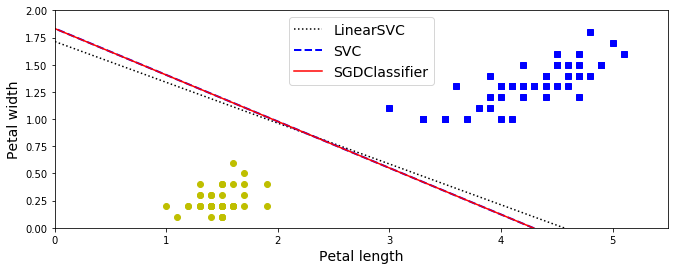

In [14]:
# Plot decision boundaries to see how close we got

# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris-Versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris-Setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

Eh, close enough

### 9) Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you'll need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can be reached?

In [15]:
from os import walk, remove, rmdir
from os.path import join, expanduser

# Helper function to determine if we need to download the MNIST data again
def find_and_remove(name, from_home=True):
    path = expanduser('~') if from_home else '/'
    for root, dirs, files in walk(path):
        if name in files:
            remove(join(root, name))
            rmdir(expanduser("~/Coding Stuff/Python/handson-ml/datasets/mldata"))

In [16]:
%%time

# First up, get the data and split it
# for this dataset, people usually just split at the 60,000 instance mark

from sklearn.datasets import fetch_mldata

home = expanduser("~/Coding Stuff/Python/handson-ml/datasets/")

# If we have the data, remove it first
find_and_remove('mnist-original.mat')

# Download and separate into data and corresponding labels
mnist = fetch_mldata("MNIST original", target_name='target', data_home=home)
X = mnist['data']
y = mnist['target']

X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

# shuffle our data to avoid issues with training
np.random.seed(42)
rnd_idx = np.random.permutation(60000) # produce a list of randomly shuffled indicies
X_train = X_train[rnd_idx]
y_train = y_train[rnd_idx]

CPU times: user 2.05 s, sys: 3.13 s, total: 5.17 s
Wall time: 31.8 s


In [17]:
# All shuffled and ready to go, now to start. LinearSVM's will automatically use one-versus-all, so we don't
# have much to do here

lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [18]:
# Let's make predictions on the training set (not the test set yet)
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

# That's a HORRIBLE score for this dataset. Linear SVC is too simple for this, but maybe just a simple
# data scaling will do it

0.8438666666666667

In [19]:
# Let's try again but with scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [20]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [21]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9218666666666666

That's much better (we cut the error rate in two), but still not great at all for MNIST. If we want to use an SVM, we will have to use a kernel. Let's try an `SVC` with an RBF kernel (the default).

**Warning**: if you are using Scikit-Learn ≤ 0.19, the `SVC` class will use the One-vs-One (OvO) strategy by default, so you must explicitly set `decision_function_shape="ovr"` if you want to use the OvR strategy instead (OvR is the default since 0.19).

In [22]:
svm_clf = SVC(decision_function_shape='ovr')
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.94615

Even better! Let's use cross validation and randomized search to tune those hyperparameters. We'll use a smaller dataset to speed this up

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {'gamma': reciprocal(0.001, 0.1), 'C': uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................
[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.8s
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.8s
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................
[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.8s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   1.0s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   1.0s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   1.0s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .. C=9.875199193765326, gamma=0.051349833451870636, total=   1.0s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .. C=9.875199193765326, gamma=0.051349833451870636, total=   1.0s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   41.0s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x110102860>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10ff1e710>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [25]:
rnd_search_cv.best_estimator_

SVC(C=8.852316058423087, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001766074650481071,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [26]:
rnd_search_cv.best_score_

0.856

This looks bad, but we only trained on a small subset of the data. Let's train on the entire training set.

*Note: Run this at night cause it'll take __hours__ to complete*

In [ ]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

That's really good! Let's test on this model and see what we get

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

Not too bad, but apparently the model is overfitting slightly. It's tempting to tweak the hyperparameters a bit more (e.g. decreasing `C` and/or `gamma`), but we would run the risk of overfitting the test set. Other people have found that the hyperparameters `C=5` and `gamma=0.005` yield even better performance (over 98% accuracy). By running the randomized search for longer and on a larger part of the training set, you may be able to find this as well.

### 10) Train an SVM regressor on the California housing dataset

In [28]:
# Fetch the data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing(data_home=home)
X = housing['data']
y = housing['target']

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# First, simple LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

# Check on training set
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.954517044073374

In [31]:
# Look at RMSE
np.sqrt(mse)

0.976993881287582

In this training set, the targets are tens of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors somewhere around $10,000. Not great. Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [32]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.0s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   4.9s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.0s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   4.8s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   4.8s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.0s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   4.3s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   4.4s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.1min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x110102dd8>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10fec26a0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [33]:
# Let's see the best estimator
rnd_search_cv.best_estimator_

SVR(C=4.745401188473625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.07969454818643928, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [35]:
# Measure RMSE on training set again
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5727524770785359

In [36]:
# Much better! Now let's try on the test set
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.5929168385528734